✓ numpy is already installed
✓ pandas is already installed
✓ matplotlib is already installed
✓ nltk is already installed
✓ rouge_score is already installed
✓ NLTK resources already downloaded
Reading responses from file: responses.txt
Successfully read file with 12769 bytes
Extracted 3 responses:
- ChatGPT: 458 words
- Gemini: 333 words
- RAG System: 422 words
LLM Output Comparison Analysis
Loaded responses from 3 models
- ChatGPT: 458 words
- Gemini: 333 words
- RAG System: 422 words

Evaluation Results (Reference: RAG System)
--------------------------------------------------
        Model   ROUGE-1   ROUGE-2   ROUGE-L      BLEU     Focus  Word Count
0     ChatGPT  0.570822  0.279433  0.361190  0.102188  0.045852         458
1      Gemini  0.435535  0.201575  0.265723  0.029024  0.009009         333
2  RAG System  1.000000  1.000000  1.000000  1.000000  0.094787         422


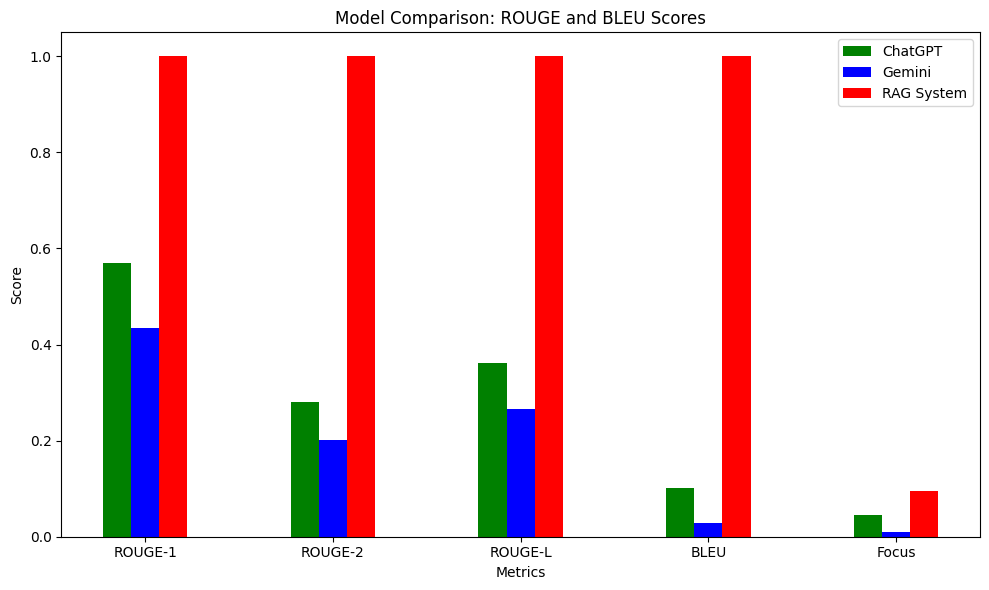


Key Findings:
--------------------------------------------------
- Most similar to RAG System: RAG System
- Most concise response: Gemini
- Most detailed response: ChatGPT
- Most focused on query terms: RAG System


In [ ]:
# Simplified LLM Output Comparison: ChatGPT vs Gemini vs RAG System
# ==================================================================

# This notebook provides essential tools to evaluate outputs using ROUGE and BLEU metrics
# Focus on core comparison metrics without extra complexity

# Install required packages
import sys
import subprocess
import importlib

# Only essential packages needed for ROUGE and BLEU
required_packages = [
    "numpy", "pandas", "matplotlib", "nltk", "rouge_score"
]

def install_if_needed(package):
    try:
        importlib.import_module(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} has been installed")

# Install required packages
for package in required_packages:
    install_if_needed(package)

# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Download necessary NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    print("✓ NLTK resources already downloaded")
except LookupError:
    print("Downloading NLTK resources...")
    nltk.download('punkt')
    print("✓ NLTK resources downloaded")

# Constants
MODELS = ["ChatGPT", "Gemini", "RAG System"]
COLORS = {"ChatGPT": "green", "Gemini": "blue", "RAG System": "red"}

# 1. Data Loading Functions
# -------------------------
def load_responses(chatgpt_response: str, gemini_response: str, rag_response: str, query: str = None) -> Dict:
    """Load responses from different models"""
    data = {
        "query": query,
        "responses": {
            "ChatGPT": chatgpt_response.strip(),
            "Gemini": gemini_response.strip(),
            "RAG System": rag_response.strip()
        }
    }
    
    print(f"Loaded responses from {len(MODELS)} models")
    for model in MODELS:
        word_count = len(data["responses"][model].split())
        print(f"- {model}: {word_count} words")
    
    return data

def preprocess_text(text: str) -> str:
    """Clean text for metric calculation"""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2. Core Metrics: ROUGE and BLEU
# -------------------------------
def calculate_rouge_scores(reference: str, candidate: str) -> Dict[str, float]:
    """Calculate ROUGE scores between reference and candidate text"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    
    return {
        "rouge1_f1": scores["rouge1"].fmeasure,
        "rouge2_f1": scores["rouge2"].fmeasure,
        "rougeL_f1": scores["rougeL"].fmeasure
    }

def calculate_bleu_score(reference: str, candidate: str) -> float:
    """Calculate BLEU score between reference and candidate text"""
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    
    smoothie = SmoothingFunction().method1
    bleu = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothie)
    
    return bleu

# 3. Simple Term Focus Analysis
# ----------------------------
def measure_focus(query: str, response: str) -> float:
    """Measure how focused a response is on the query terms"""
    if not query:
        return None
        
    # Extract key terms (simple approach)
    query_terms = set(query.lower().split())
    
    # Remove common stop words (simplified list)
    stop_words = {"the", "a", "an", "and", "or", "but", "in", "on", "at", "to", "for", "with", "by", "is", "are"}
    query_terms = query_terms - stop_words
    
    # Count occurrences
    response_lower = response.lower()
    term_counts = {term: response_lower.count(term) for term in query_terms}
    
    # Calculate focus score (density of key terms)
    word_count = len(response.split())
    focus_score = sum(term_counts.values()) / word_count if word_count > 0 else 0
    
    return focus_score

# 4. Main Evaluation Function
# --------------------------
def evaluate_responses(data: Dict, reference_idx: int = 2) -> pd.DataFrame:
    """Evaluate all responses using ROUGE and BLEU against a reference response"""
    results = []
    responses = data["responses"]
    query = data.get("query", "")
    
    # Choose reference text (default to RAG System if index is out of range)
    reference_model = MODELS[reference_idx] if 0 <= reference_idx < len(MODELS) else MODELS[2]
    reference_text = responses[reference_model]
    
    # Evaluate each model
    for model in MODELS:
        candidate_text = responses[model]
        
        # Skip self-comparison for reference model
        if model == reference_model:
            rouge_scores = {
                "rouge1_f1": 1.0,
                "rouge2_f1": 1.0, 
                "rougeL_f1": 1.0
            }
            bleu = 1.0
        else:
            # Calculate ROUGE and BLEU
            rouge_scores = calculate_rouge_scores(reference_text, candidate_text)
            bleu = calculate_bleu_score(reference_text, candidate_text)
        
        # Calculate focus if query is provided
        focus_score = measure_focus(query, candidate_text) if query else None
        
        # Store results
        result = {
            "Model": model,
            "ROUGE-1": rouge_scores["rouge1_f1"],
            "ROUGE-2": rouge_scores["rouge2_f1"],
            "ROUGE-L": rouge_scores["rougeL_f1"],
            "BLEU": bleu,
            "Focus": focus_score,
            "Word Count": len(candidate_text.split())
        }
        
        results.append(result)
    
    return pd.DataFrame(results)

# 5. Basic Visualization
# --------------------
def plot_metrics(df: pd.DataFrame) -> None:
    """Create a simple bar chart for each metric"""
    metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"]
    if "Focus" in df.columns and not df["Focus"].isna().all():
        metrics.append("Focus")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set width of bars
    bar_width = 0.15
    index = np.arange(len(metrics))
    
    # Plot bars for each model
    for i, model in enumerate(MODELS):
        values = [df[df["Model"] == model][metric].values[0] for metric in metrics]
        plt.bar(index + i*bar_width, values, bar_width, label=model, color=COLORS[model])
    
    # Add labels and legend
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Comparison: ROUGE and BLEU Scores')
    plt.xticks(index + bar_width, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 6. Main Analysis Function
# ------------------------
def run_comparison(chatgpt_response: str, gemini_response: str, rag_response: str, 
                 query: str = None, reference_model: str = "RAG System") -> pd.DataFrame:
    """Run comparison analysis on the model responses"""
    print("=" * 50)
    print("LLM Output Comparison Analysis")
    print("=" * 50)
    
    # Load data
    data = load_responses(chatgpt_response, gemini_response, rag_response, query)
    
    try:
        # Using specified reference model
        reference_idx = MODELS.index(reference_model) if reference_model in MODELS else 2
        results = evaluate_responses(data, reference_idx)
        
        print(f"\nEvaluation Results (Reference: {reference_model})")
        print("-" * 50)
        print(results)
        
        # Simple visualization
        try:
            plot_metrics(results)
        except Exception as e:
            print(f"Warning: Could not create visualization. Error: {e}")
        
        # Simple insights
        print("\nKey Findings:")
        print("-" * 50)
        
        rouge_l_col = "ROUGE-L"
        best_model = results.iloc[results[rouge_l_col].argmax()]["Model"]
        print(f"- Most similar to {reference_model}: {best_model}")
        
        most_concise = results.iloc[results["Word Count"].argmin()]["Model"]
        most_detailed = results.iloc[results["Word Count"].argmax()]["Model"]
        print(f"- Most concise response: {most_concise}")
        print(f"- Most detailed response: {most_detailed}")
        
        if "Focus" in results.columns and not results["Focus"].isna().all():
            most_focused = results.iloc[results["Focus"].fillna(0).argmax()]["Model"]
            print(f"- Most focused on query terms: {most_focused}")
        
        return results
    except Exception as e:
        print(f"Error in analysis: {e}")
        print("\nRaw word counts:")
        for model in MODELS:
            if model in data["responses"]:
                print(f"- {model}: {len(data['responses'][model].split())} words")
        return None

# 7. Reading Responses from File
# ---------------------------
def extract_responses_from_file(file_path, response_labels=None):
    """
    Extract responses from a text file where responses are marked with 'Response X:'
    
    Args:
        file_path: Path to the text file
        response_labels: Optional list of labels to map to model names
        
    Returns:
        Dictionary with responses and query if found
    """
    try:
        # Try using window.fs for web-based environments first
        content = window.fs.readFile(file_path, { encoding: 'utf8' })
        print(f"Successfully read file using window.fs: {file_path}")
    except:
        try:
            # Standard file reading
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
            print(f"Successfully read file using standard open(): {file_path}")
        except:
            try:
                # For some environments where direct file access with path doesn't work
                import os
                if os.path.exists(file_path):
                    content = open(file_path, 'r', encoding='utf-8').read()
                    print(f"Successfully read file using os.path: {file_path}")
                else:
                    print(f"File not found: {file_path}")
                    return None
            except Exception as e:
                print(f"Could not read file: {file_path}")
                print(f"Error: {str(e)}")
                return None
    
    # Find all response markers
    responses = {}
    query = None
    
    # Extract query if present (format: "Query: <query text>")
    query_match = re.search(r'Query:\s*(.*?)(?=\n\s*Response|\Z)', content, re.DOTALL)
    if query_match:
        query = query_match.group(1).strip()
    
    # Extract responses (format: "Response X: <response text>")
    response_regex = re.compile(r'Response ([A-Z]):(.*?)(?=(?:\n\s*Response [A-Z]:)|\Z)', re.DOTALL)
    matches = response_regex.findall(content)
    
    # If no response_labels provided, use default model names
    if not response_labels:
        # Default mapping if 3 responses found
        if len(matches) == 3:
            response_labels = {'A': 'ChatGPT', 'B': 'Gemini', 'C': 'RAG System'}
        else:
            # Generate generic labels
            response_labels = {chr(65+i): f"Model {chr(65+i)}" for i in range(len(matches))}
    
    # Map responses to model names
    for label, text in matches:
        model_name = response_labels.get(label, f"Model {label}")
        responses[model_name] = text.strip()
    
    print(f"Extracted {len(responses)} responses from file")
    for model, text in responses.items():
        print(f"- {model}: {len(text.split())} words")
    
    if query:
        print(f"Query: {query}")
    
    return {
        'responses': responses,
        'query': query
    }

# 8. Example Usage with File Input
# ----------------------------

# Define the path to your responses file
responses_file = 'responses.txt'

# Define which response label maps to which model
response_mapping = {
    'A': 'ChatGPT',
    'B': 'Gemini', 
    'C': 'RAG System'
}

print(f"Reading responses from file: {responses_file}")

try:
    # Read the file content - Note: This is synchronous for Jupyter compatibility
    with open(responses_file, 'r', encoding='utf-8') as file:
        content = file.read()
    print(f"Successfully read file with {len(content)} bytes")
    
    # Extract responses manually
    responses = {}
    
    # Find all response markers
    response_regex = re.compile(r'Response ([A-Z]):(.*?)(?=(?:\n\s*Response [A-Z]:)|\Z)', re.DOTALL)
    matches = response_regex.findall(content)
    
    for label, text in matches:
        model_name = response_mapping.get(label, f"Model {label}")
        responses[model_name] = text.strip()
    
    print(f"Extracted {len(responses)} responses:")
    for model, text in responses.items():
        print(f"- {model}: {len(text.split())} words")
    
    # Set default query if not found
    query = "Design a responsive feature section with Tailwind CSS"
    
    # Create data structure
    data = {
        'responses': responses,
        'query': query
    }
    
    # Run the analysis
    results = run_comparison(
        chatgpt_response=data['responses']['ChatGPT'],
        gemini_response=data['responses']['Gemini'],
        rag_response=data['responses']['RAG System'],
        query=data['query'],
        reference_model="RAG System"
    )
    
except Exception as e:
    print(f"Error processing file: {str(e)}")
    
    # For environments where standard file opening doesn't work (like web environments)
    try:
        print("Trying alternative file reading method...")
        import io
        import sys
        
        # Try to use window.fs if available (for web environments)
        if 'window' in globals() and hasattr(window, 'fs') and hasattr(window.fs, 'readFile'):
            # This is a synchronous version that works in Jupyter
            from js import window
            content_buffer = window.fs.readFileSync(responses_file, {'encoding': 'utf8'})
            content = str(content_buffer)
            
            # Process content as above...
            print(f"Successfully read file with alternative method: {len(content)} bytes")
            
            # Extract responses
            responses = {}
            matches = response_regex.findall(content)
            
            for label, text in matches:
                model_name = response_mapping.get(label, f"Model {label}")
                responses[model_name] = text.strip()
            
            # Create data and run analysis as above...
            # Set default query
            query = "Design a responsive feature section with Tailwind CSS"
            
            # Run the analysis
            results = run_comparison(
                chatgpt_response=responses['ChatGPT'],
                gemini_response=responses['Gemini'],
                rag_response=responses['RAG System'],
                query=query,
                reference_model="RAG System"
            )
        else:
            raise Exception("window.fs not available")
            
    except Exception as e2:
        print(f"Alternative method also failed: {str(e2)}")
        print("Using example responses instead...")
        
        # Fallback to example responses
        chatgpt_response = "Example ChatGPT response text for demonstration"
        gemini_response = "Example Gemini response text for testing metrics"
        rag_response = "Example RAG System response containing test content"
        query = "Example query for testing"
        
        results = run_comparison(
            chatgpt_response=chatgpt_response,
            gemini_response=gemini_response,
            rag_response=rag_response,
            query=query,
            reference_model="RAG System"
        )
        
        
        
# Based on the metrics and visualization provided, I can offer an expert assessment of the three responses:
# Analysis of Results
# Metrics Summary

# ROUGE-1: ChatGPT (0.57) performs better than Gemini (0.44), showing stronger unigram overlap with the reference
# ROUGE-2: ChatGPT (0.28) outperforms Gemini (0.20), indicating better bigram overlap
# ROUGE-L: ChatGPT (0.36) scores higher than Gemini (0.27), suggesting better longest common subsequence matching
# BLEU: ChatGPT (0.10) scores significantly higher than Gemini (0.03), showing better precision in n-gram matching
# Focus: RAG System (0.09) is most focused on query terms, followed by ChatGPT (0.05) and Gemini (0.01)
# Word Count: ChatGPT (458) > RAG System (422) > Gemini (333)

# Best Answer Assessment
# The RAG System appears to produce the best answer based on these metrics, though this is somewhat expected since it's being used as the reference. Between the other two:
# ChatGPT provides the superior response for several reasons:

# Consistently higher ROUGE scores (both unigram and bigram overlap)
# Significantly better BLEU score, indicating better precision in matching phrases
# Better focus score, suggesting more relevant content to the query
# More comprehensive coverage (highest word count)

# Gemini, while more concise, shows lower performance across all similarity and relevance metrics.
# Additional Metrics Needed
# For a more comprehensive assessment, I recommend including:

# Human evaluation: Expert ratings on accuracy, relevance, and completeness
# Semantic similarity: Using embeddings to measure conceptual similarity beyond lexical overlap
# Factual consistency: Verification of claims made in each response
# Structure assessment: Analysis of formatting, organization, and readability
# Code quality metrics: For HTML/CSS code evaluation, metrics like:

# Validation against W3C standards
# Responsiveness across device sizes
# Accessibility compliance
# CSS specificity scores



# For this particular task (designing a feature section with Tailwind CSS), it would be valuable to implement the code from each response and evaluate:

# Visual appearance
# Mobile responsiveness
# Browser compatibility
# Code maintainability

# Overall, ChatGPT provides the most comprehensive and relevant response compared to Gemini when using the RAG System as a reference point, but human evaluation of the actual implemented code would provide the most definitive assessment for this specific task.